# Lattice 2D

In [1]:
%matplotlib inline
#
from LRGSG_package.LRGSG import *
from LRGSG_package.config.LRGSG_plots import imshow_colorbar_caxdivider
#
move_to_rootf(print_tf=True)

cwd: /home/opisthofulax/PhD/projects/complex-networks/LRG-Signed


### Square Lattice Eigenvalue

In [14]:
lattices = {}
eigs = {}
kwargs = {}
sizes = [16, 32, 64, 128]
modeflip = 'pflip_square'
pflip = 0.203
for side in sizes:
    if modeflip in ['random', 'pflip_cross', 'pflip_square']:
        kwargs['pflip'] = pflip
    lattices[side] = Lattice2D(#
        side1 = side,
        geometry = 'squared',
        **kwargs
    )
    lattice = lattices[side]
    #
    lattice.init_weights()
    if modeflip == 'one':
        lattice.flip_sel_edges(lattice.neg_weights_dict.DEFAULT_NEG_WEIGHTS_DICT_H, 'H')
    elif modeflip == 'cross':
        lattice.flip_sel_edges(lattice.neg_weights_dict.NEG_WEIGHTS_DICT_H_CROSS, 'H')
    elif modeflip == 'pflip_cross':
        lattice.flip_sel_edges(lattice.neg_weights_dict.NEG_WEIGHTS_DICT_H_PCROSS, 'H')
    elif modeflip == 'pflip_square':
        lattice.flip_sel_edges(lattice.neg_weights_dict.NEG_WEIGHTS_DICT_H_PSQUARE, 'H')
    elif modeflip == 'square':
        lattice.flip_sel_edges(lattice.neg_weights_dict.NEG_WEIGHTS_DICT_H_SQUARE, 'H')
    elif modeflip == '2adj':
        lattice.flip_sel_edges(lattice.neg_weights_dict.NEG_WEIGHTS_DICT_H_2ADJ, 'H')
    elif modeflip == '2cont':
        lattice.flip_sel_edges(lattice.neg_weights_dict.NEG_WEIGHTS_DICT_H_2CONT, 'H')
    elif modeflip == 'random':
        lattice.flip_random_fract_edges()
    elif modeflip == 'radius':
        lattice.flip_sel_edges(lattice.neg_weights_dict.get_neg_weights_dict_h_rball(), 'H')
    lattice.compute_k_eigvV()

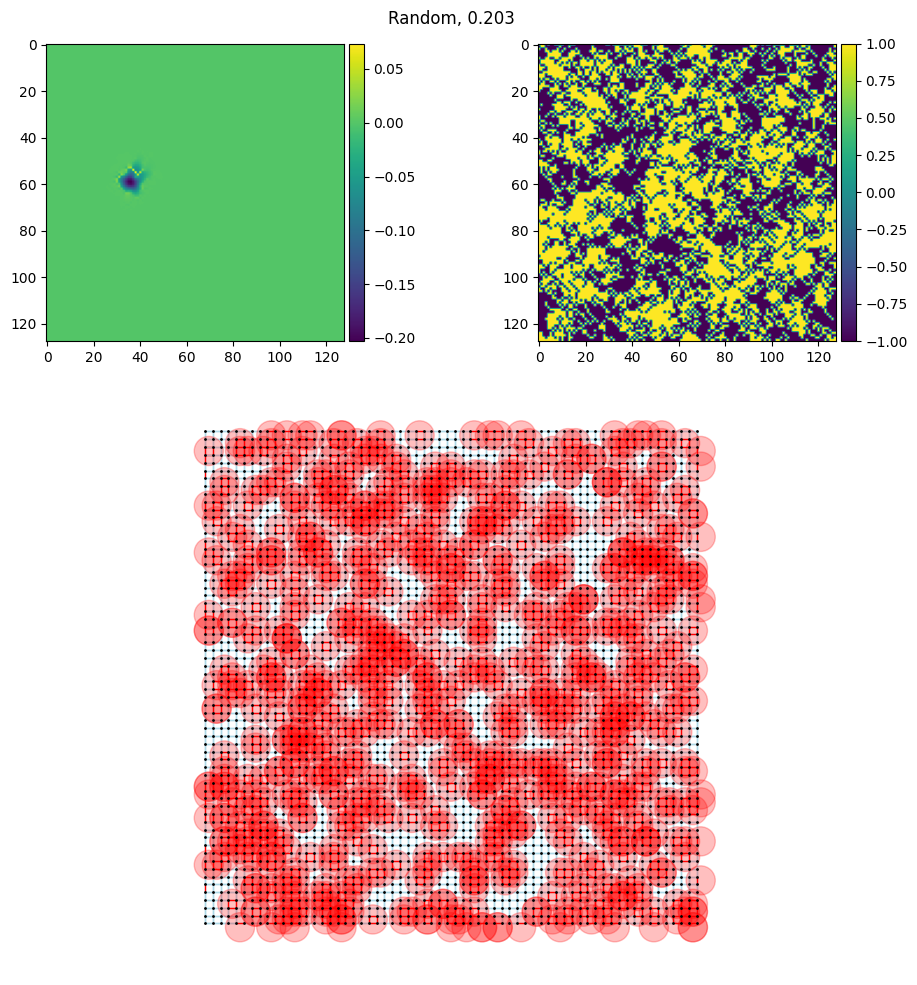

In [15]:
size = sizes[-1]
size_grid = sizes[2]
arr = lattices[size].eigV[0].reshape(lattices[size].syshape)
binarized_arr = np.where(arr > 0, 1, -1)

G = lattices[size_grid].G
G_edges_ww = G.edges(data='weight')
edgecol = ['lightblue' if e[2] > 0 else 'r' for e in G_edges_ww]
rotated_pos = {node: (y, -x) for (x, y), node in zip(lattices[size_grid].posG.values(), G.nodes())}
#
#
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 2])  # 2 rows, 2 columns, with the second row twice the height of the first
ax = []
ax.append(fig.add_subplot(gs[0, 0]))  # First row, first column
ax.append(fig.add_subplot(gs[0, 1]))  # First row, second column
ax.append(fig.add_subplot(gs[1, :]))

#
im0 = ax[0].imshow(arr)
_ = imshow_colorbar_caxdivider(im0, ax[0])
im1 = ax[1].imshow(binarized_arr)
_ = imshow_colorbar_caxdivider(im1, ax[1])

nx.draw(G, 
        pos=rotated_pos, 
        ax=ax[2],  
        edge_color=edgecol, node_color='k', node_size=1, with_labels=False)
ax[2].set_aspect('equal')

if modeflip in ['random', 'pflip_cross', 'pflip_square']:
    if modeflip in ['pflip_cross', 'pflip_square']:
        if modeflip  == 'pflip_cross':
            nt = lambda i: (i[1], -i[0])
        elif modeflip  == 'pflip_square':
            nt = lambda i: (i[1]+.5, -i[0]-.5)
        for i in lattices[size_grid].neg_weights_dict.flip_selection:
            original_tuple = lattices[size_grid].invnode_map[i]  
            new_tuple = nt(original_tuple)
            circle_center = new_tuple  # Coordinates for the center of the circle
            circle = plt.Circle(circle_center, lattices[size_grid].r_c, color='red', alpha=0.25)
            ax[2].add_patch(circle)
    elif modeflip == 'random':
        negw = [(u, v) for u, v, w in lattices[size_grid].H.edges(data='weight') if w == -1]
        def nt(u, v):
            tt = tuple((np.array(lattices[size_grid].invnode_map[u]) + np.array(lattices[size_grid].invnode_map[v]))/2)
            tt = (tt[1], -tt[0])
            return tt
        lattices[size_grid].neg_weights_dict.flip_selection = [u for u, _, w in lattices[size_grid].H.edges(data='weight') if w == -1]
        for i in negw:
            new_tuple = nt(*i)
            circle_center = new_tuple  # Coordinates for the center of the circle
            circle = plt.Circle(circle_center, lattices[size_grid].r_c, color='red', alpha=0.25)
            ax[2].add_patch(circle)

    # edgepos = [e[1] for e in G_edges_ww if e[2] < 0]
    # for i in edgepos:
    #     original_tuple = i
    #     new_tuple = (original_tuple[1]-.5, -original_tuple[0])
    #     circle_center = new_tuple  # Coordinates for the center of the circle
    #     circle = plt.Circle(circle_center, lattice.r_c, color='red', alpha=0.25)
    #     ax[2].add_patch(circle)

fig.suptitle(f"Random, {lattices[size].pflip:.3g}" if lattices[size].pflip > 0 else f"Single {modeflip} defect")
fig.tight_layout()
savename = f"data/plot/eigv_p={lattices[size].pflip:.3g}.pdf" if lattices[size].pflip > 0 else f"data/plot/eigv_{modeflip}defect.pdf"
fig.savefig(savename, bbox_inches='tight')

### Field along cut

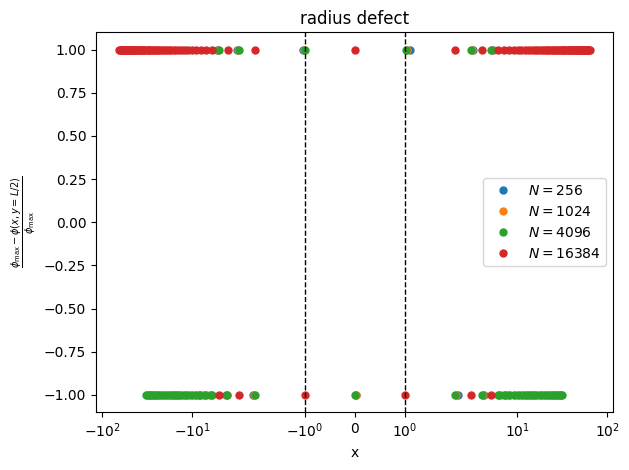

In [12]:
fig, ax = plt.subplots()

if modeflip in ['one', '2adj', '2cont', 'radius']:
    xshift = -.5
elif modeflip in ['cross', 'random']:
    xshift = -.5
elif modeflip in ['square']:
    xshift = -1

for side in sizes:
    eigen_state = lattices[side].eigV[0].reshape(lattices[side].syshape)
    # print((eigen_state > 0).sum())
    if (eigen_state > 0).sum() == lattices[side].N or (eigen_state > 0).sum() == lattices[side].N-1:
        eigen_state *= -1
    # print((eigen_state > 0).sum())
    phi_plot = eigen_state#(np.max(eigen_state)-eigen_state)/np.max(eigen_state)
    # phi_plot = inf_array_regularization(phi_plot)
    #
    halfsize = lattices[side].side1//2
    cut = phi_plot[:, halfsize]
    x = np.linspace(0, len(cut), num=len(cut))-halfsize+xshift
    y = cut/np.max(cut)
    y[np.abs(y) < 1e-5] =0
    ax.plot(x, y, 'o-',lw=0, markersize=5, label=fr"$N={side**2}$")

ax.set_ylabel(r'$\frac{\phi_\max-\phi(x, y=L/2)}{\phi_\max}$')
ax.set_xlabel('x')
ax.legend()
# ax.set_yscale('log')
ax.set_xscale('symlog') 
ax.axvline(-1, ls='--', lw=1, c='k')
ax.axvline(+1, ls='--', lw=1, c='k')
ax.set_title(f"{modeflip} defect")
fig.tight_layout()
savename = f"data/plot/phimax_p={lattices[sizes[-1]].pflip:.3g}_{ax.get_xscale()}.pdf" if lattices[sizes[-1]].pflip > 0 else f"data/plot/phimax_{modeflip}defect_{ax.get_xscale()}.pdf"
fig.savefig(savename, bbox_inches='tight')

### Signed Laplacian Dynamics with FBC
- fai per triangolare
- sottrai magn e v_0, effetto di bordo
- vedi con FBC

- fixed periodic sopra spin glass
- without rescaling
- fisso stato stazionario come una costante, al variare della taglia
- verifica matrice di jordan a blocchi
- prova a vedere se il numero di nodi che riesci a toccare quando  la matrice di adiacenza e riempita a 0.103 scala con N prendi il cammino piu lungo che riesci a fare

In [1]:
%matplotlib inline
#
from LRGSG_package.LRGSG import *
#
move_to_rootf(print_tf=True)

cwd: /home/opisthofulax/PhD/projects/complex-networks/LRG-Signed


In [3]:
lattice = Lattice2D(#
    side1 = 128,
    geometry = 'squared',
    pbc = False
)
lattice.flip_sel_edges(lattice.neg_weights_dict.get_neg_weights_dict_h_rball(R=5))
lrgsg = SignedLaplacianAnalysis(  #
    sg=lattice, 
    initCond="all_1", 
    t_steps=10, 
    no_obs=200
)

In [4]:
lrgsg.run_laplacian_dynamics()

Beginning Laplacian dynamics.


100%|██████████| 16383/16383 [00:04<00:00, 3378.48it/s]


(55.0, 73.0)

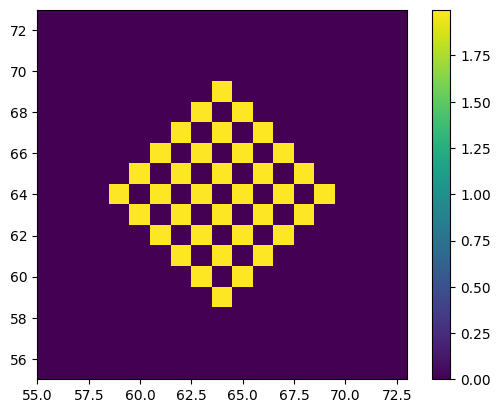

In [18]:
plt.imshow((np.max(lrgsg.field.reshape(lattice.syshape))-lrgsg.field.reshape(lattice.syshape)))
plt.colorbar()
plt.xlim(55, 73)
plt.ylim(55, 73)

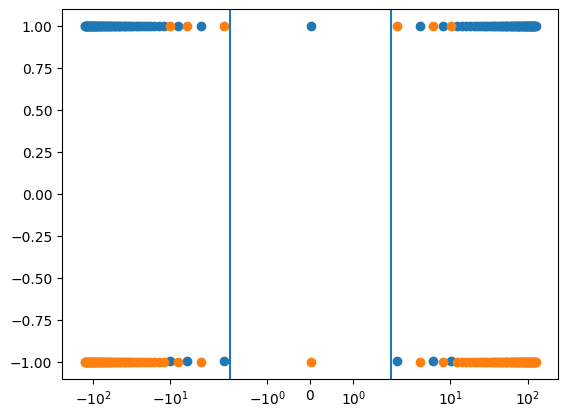

In [13]:
x = np.linspace(-128, 128, num=len(lrgsg.field.reshape(lattice.syshape)))-1
plt.plot(x, lrgsg.field.reshape(lattice.syshape)[:, 64], 'o')
plt.plot(x, -lattice.eigV[0].reshape(lattice.syshape)[:, 64]/np.max(np.abs(lattice.eigV[0].reshape(lattice.syshape)[:, 64])), 'o')

plt.xscale('symlog')
plt.axvline(-lattice.r_c)
plt.axvline(lattice.r_c)

In [27]:
# ax.axvline(-1, ls='--', c='k')
# ax.axvline(1, ls='--', c='k')
# axins = ax.inset_axes(
#     [0.75, 0.3, 0.2, 0.4],
#     xlim=(-10, 10), ylim=(0.98, 1.5), xticklabels=[], yticklabels=[])

# for side in sizes:
#     eigen_state = np.abs(eigs[side])
#     phi_plot = np.log((np.max(eigen_state) - eigen_state)/np.max(eigen_state))
#     phi_plot_nnans = phi_plot[(phi_plot != np.inf) & (phi_plot != -np.inf)]
#     phi_plot = np.nan_to_num(phi_plot, posinf=np.max(phi_plot_nnans), neginf=np.min(phi_plot_nnans))
#     #
#     halfsize = lattices[side].side1//2
#     cut = phi_plot[:, halfsize]
#     x = np.linspace(0, len(cut), num=len(cut))-halfsize
#     axins.plot(x-0.5, cut/np.max(cut), 'o-',lw=1, markersize=5, label=fr"$N={side**2}$")

# for aax in [ax, axins]:
#     aax.axvline(-1, ls='--', c='k')
#     aax.axvline(1, ls='--', c='k')
# axins.set_xscale('symlog') 
# ax.indicate_inset_zoom(axins, edgecolor="black")

In [11]:


# phi_asym = hcut_halfsize[SLRG_obj.system.side1//2:]
# x = np.linspace(0, len(phi_asym), num=len(phi_asym))

# idx = 5
# params, cov = curve_fit(line, x[:idx], phi_asym[:idx])
# ax.plot(x, line(x, *params))


NameError: name 'theLattice' is not defined

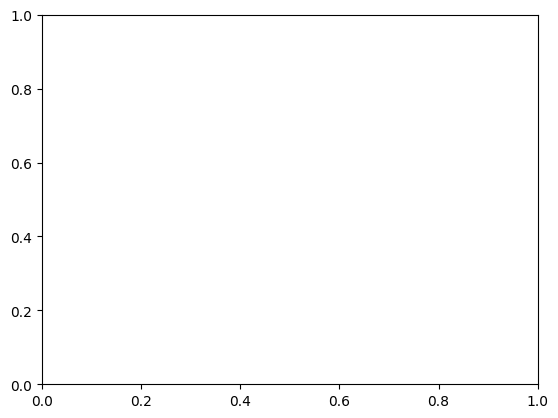

In [12]:
fig, ax = plt.subplots()

cut = phi_plot[:, halfsize]
cutstart = len(cut)//2+20
cutend = cutstart+50

cutcut = cut[cutstart:cutend]
x = np.linspace(cutstart, cutend, num=len(cutcut))-theLattice.side1//2
x2 = np.linspace(0, len(cut), num=len(cut))-theLattice.side1//2
ax.plot(x2, cut, 'bo')
# ax.plot(x, cutcut, 'ro')
params, cov = curve_fit(line, x, cutcut)
# ax.plot(x, line(x, *params))

ax.set_ylabel(r'$\log(\phi_\max-\phi(x, y=L/2))$')
ax.set_xlabel('x')
# plt.xscale('symlog')
# xx = np.linspace(0, SLRG_obj.system.side1//2)
# ax.plot(xx+50, line(xx, *params))
# plt.yscale('log')

In [1]:
%matplotlib inline
#
from LRGSG_package.LRGSG import *
#
move_to_rootf(print_tf=True)

cwd: /home/opisthofulax/PhD/projects/complex-networks/LRG-Signed


In [2]:
lattice = Lattice2D(#
    side1 = 256,
    geometry = 'squared',
    pflip = 0.05
)
lattice.flip_random_fract_edges()
lattice.compute_k_eigvV()

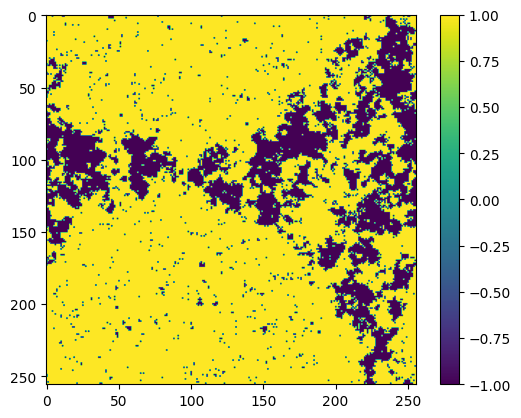

In [3]:
plt.imshow(lattice.bin_eigV().reshape(lattice.syshape))
plt.colorbar()

In [4]:
def dfs_pbc(grid, x, y, visited):
    rows, cols = len(grid), len(grid[0])
    # Apply PBC using modulo operations
    x_next = x % rows
    y_next = y % cols
    
    if visited[x_next][y_next] or grid[x_next][y_next] == -1:  # Updated to check for -1
        return 0
    
    visited[x_next][y_next] = True  # Mark the current cell as visited
    size = 1  # Current cell is a new part of the cluster
    # Recursively visit all connecting neighbors with PBC
    size += dfs_pbc(grid, (x_next+1) % rows, y_next, visited)  # Apply PBC here
    size += dfs_pbc(grid, (x_next-1) % rows, y_next, visited)  # And here
    size += dfs_pbc(grid, x_next, (y_next+1) % cols, visited)  # Also here
    size += dfs_pbc(grid, x_next, (y_next-1) % cols, visited)  # And here
    return size

def count_cluster_distribution_pbc(grid):
    rows, cols = len(grid), len(grid[0])
    visited = [[False for _ in range(cols)] for _ in range(rows)]
    cluster_sizes = []

    for i in range(rows):
        for j in range(cols):
            if grid[i][j] != -1 and not visited[i][j]:  # Updated to check for not -1
                cluster_size = dfs_pbc(grid, i, j, visited)
                cluster_sizes.append(cluster_size)

    # Get distribution of cluster sizes
    cluster_distribution = {}
    for size in cluster_sizes:
        if size in cluster_distribution:
            cluster_distribution[size] += 1
        else:
            cluster_distribution[size] = 1
    
    return cluster_distribution

# Example usage with PBC and -1 as the non-cluster value
grid_pbc = [
    [1, -1, 1, 1],
    [1, 1, -1, -1],
    [-1, -1, 1, -1],
    [1, -1, 1, 1]
]

distribution_pbc = count_cluster_distribution_pbc(grid_pbc)
print(distribution_pbc)


{9: 1}


In [19]:
from collections import Counter

merged_counter = Counter()
for i in range(100):
    lattice = Lattice2D(#
        side1 = 128,
        geometry = 'squared',
        pflip = 0.206
    )
    lattice.flip_random_fract_edges()
    lattice.compute_k_eigvV()
    distribution_pbc = count_cluster_distribution_pbc(lattice.bin_eigV().reshape(lattice.syshape))
    merged_counter += Counter(distribution_pbc)

# Convert back to a regular dictionary, if needed
merged_dict = dict(merged_counter)

In [20]:
P = distribution_pbc.items()

In [21]:
data_list = [key for key, count in merged_dict.items() for _ in range(count)]

binc, hist, bw = log_binning(data_list, 8)

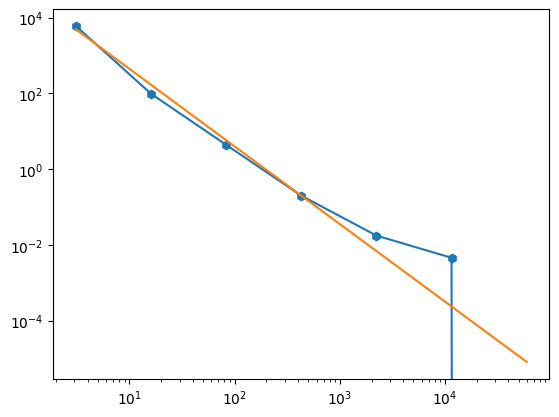

In [23]:
plt.plot(binc, hist/bw, 'h-')
plt.plot(binc, 50000*(1.0*np.array(binc))**(-2.05))

plt.xscale('log')
plt.yscale('log')
# plt.xlim([1, 2e4])

(0.1, 1000.0)

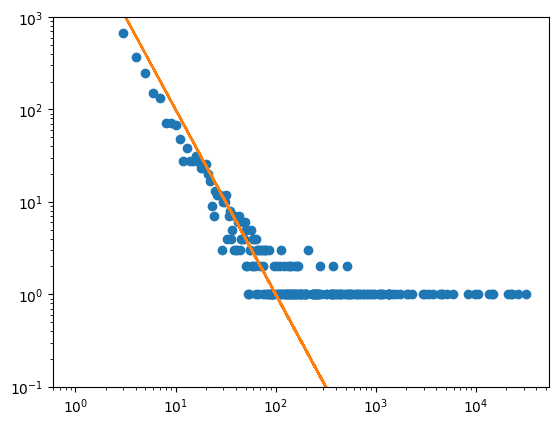

In [39]:
sizes = list(merged_dict.keys())
frequencies = list(merged_dict.values())
plt.plot(sizes, frequencies, 'o')
plt.xscale('log')
plt.yscale('log')
plt.plot(sizes, 10000*(1.0*np.array(sizes))**(-2))
plt.ylim([1e-1, 1e3])

In [31]:
np.array(sizes)*1.0

array([5.5200e+02, 1.0000e+00, 3.0000e+00, 1.1000e+01, 3.6000e+01,
       2.0532e+04, 2.0000e+00, 2.6000e+01, 5.0000e+00, 9.0000e+00,
       4.0000e+00, 7.0000e+00, 6.0000e+00, 3.0000e+01, 1.0000e+01,
       1.4000e+01, 8.0000e+00, 2.1000e+01, 1.4000e+02, 3.9000e+01,
       4.0000e+01, 1.3000e+01, 1.1930e+03, 4.9000e+01, 4.7100e+02,
       2.3000e+01, 1.3300e+02, 1.6000e+01, 1.2000e+01, 3.1100e+02,
       5.4000e+01, 6.7000e+01, 2.0000e+01, 2.5000e+01, 1.1360e+03,
       8.0000e+01, 4.4000e+02, 7.4000e+01, 2.2200e+02, 1.5000e+01,
       1.2580e+03, 5.1000e+01, 1.6100e+02, 1.0400e+03, 1.8000e+01,
       5.2000e+01, 4.7000e+01, 7.1000e+01, 3.2000e+01, 5.8000e+01,
       2.3000e+02, 4.5000e+01, 7.3000e+01, 3.5000e+01])